# Tennessee's Student Teacher Achievement Ratio (STAR) project

In [10]:
# Load libraries
#!pip install pyreadstat
#!pip install econml

import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.model_selection as ms
from scipy.stats import norm
from econml.dml import CausalForestDML

In [11]:
# Define the paths for the SAV files
HS_path = "../data/PROJECTSTAR/STAR_High_Schools.sav"
K3_path = "../data/PROJECTSTAR/STAR_K-3_Schools.sav"
Students_path = "../data/PROJECTSTAR/STAR_Students.sav"
Comparison_path = "../data/PROJECTSTAR/Comparison_Students.sav"

# Load the datasets
data_HS = pd.read_spss(HS_path)
data_K3 = pd.read_spss(K3_path)
data_Students = pd.read_spss(Students_path)
data_Comparison = pd.read_spss(Comparison_path)

In [12]:
# Display the summary information High School schools
display(data_HS.head())

,hsid,SCHLURBN,ENRLMENT,seniors,lowgradelevel,HGHGRADE,NUMGRADE,MNRTYPCT,FRLCHPCT,NOGRDPCT,...,analytical,solidgeo,LINALGBR,FRENCH,FREHILVL,SPANISH,SPNHILVL,LATIN,LTNHILVL,LNGHILVL
0,106017.0,SUBURBAN,1500.0,375.000000,9.0,12.0,4.0,2.0,10.0,4.0,...,NO,NO,YES,1.0,5.0,1.0,5.0,0.0,NaN,5.0
1,112032.0,RURAL,400.0,66.666667,7.0,12.0,6.0,5.0,20.0,12.0,...,NO,NO,NO,0.0,NaN,1.0,2.0,0.0,NaN,2.0
2,112034.0,URBAN,1100.0,275.000000,9.0,12.0,4.0,35.0,30.0,12.0,...,YES,YES,NO,1.0,4.0,1.0,4.0,0.0,NaN,4.0
3,112036.0,RURAL,428.0,107.000000,9.0,12.0,4.0,4.1,20.8,NaN,...,NO,NO,NO,1.0,2.0,1.0,2.0,0.0,NaN,2.0
4,118044.0,RURAL,450.0,37.500000,1.0,12.0,12.0,0.0,63.0,12.0,...,YES,NO,NO,0.0,NaN,1.0,2.0,0.0,NaN,2.0


In [13]:
# Display the summary information Kindergarten schools
display(data_K3.head())

,schid,SCHLURBN,GRDRANGE,FLAGGK,FLAGG1,FLAGG2,FLAGG3,GKENRMNT,GKCHAPT1,GKFRLNCH,...,G3AVGDMB,G3CHAPT1,G3FRLNCH,G3BUSED,G3NATVAM,G3ASIAN,G3BLACK,G3HSPANC,G3WHITE,G3OTHRAC
0,112038.0,URBAN,K-5,Yes,Yes,Yes,Yes,330.0,YES,67.0,...,400.0,YES,65.0,57.0,0.0,2.0,32.0,0.0,66.0,0.0
1,123056.0,RURAL,K-8,Yes,Yes,Yes,Yes,620.0,YES,35.0,...,591.0,YES,30.0,98.0,0.0,0.0,1.0,0.0,99.0,0.0
2,128068.0,RURAL,K-8,Yes,No,No,No,540.0,YES,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,128076.0,SUBURBAN,K-8,Yes,Yes,Yes,Yes,564.0,NO,10.0,...,504.0,NO,23.0,90.0,0.0,0.0,3.0,0.0,97.0,0.0
4,128079.0,RURAL,K-5,Yes,Yes,Yes,Yes,471.0,YES,34.0,...,504.0,YES,32.0,72.0,0.0,0.0,5.0,0.0,95.0,0.0


In [14]:
# Display the summary information Students
display(data_Students.head())
display(data_Students.info())

,stdntid,gender,race,birthmonth,birthday,birthyear,FLAGSGK,FLAGSG1,FLAGSG2,FLAGSG3,...,hsactcomp,hsacttot,hsactenglish,hsactmath,hsactread,hsactscience,hssatconverted,hsactconverted,hsgrdadd,hsgrdcol
0,10000.0,MALE,WHITE,JANUARY,22.0,1979.0,NO,YES,YES,YES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001.0,MALE,WHITE,FEBRUARY,20.0,1980.0,YES,NO,NO,NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002.0,FEMALE,BLACK,JULY,21.0,1979.0,NO,NO,NO,YES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DROPPED OUT,NO
3,10003.0,MALE,WHITE,MAY,28.0,1980.0,NO,YES,YES,YES,...,22.0,89.0,16.0,21.0,28.0,24.0,860.0,22.0,GRADUATED,YES
4,10004.0,FEMALE,BLACK,JANUARY,2.0,1980.0,NO,NO,YES,YES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DROPPED OUT,NO


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11601 entries, 0 to 11600
Columns: 379 entries, stdntid to hsgrdcol
dtypes: category(158), float64(221)
memory usage: 21.3 MB


None

## Data analysis

In [15]:
# Define the treatment variables 'gkclasstype', 'g1classtype', 'g2classtype', 'g3classtype'
treatment_variables = ['gkclasstype', 'g1classtype', 'g2classtype', 'g3classtype']

# Initialize an empty DataFrame to store the counts
class_type_counts = pd.DataFrame()

# Loop through each treatment variable
for var in treatment_variables:
    # Count the number of observations for each class type
    counts = data_Students[var].value_counts()
    
    # Append the counts to the class_type_counts DataFrame
    class_type_counts[var] = counts

# Display the counts of observations for each class type group
print("Counts of Observations for Each Class Type Group:")
display(class_type_counts)

Counts of Observations for Each Class Type Group:


,gkclasstype,g1classtype,g2classtype,g3classtype
gkclasstype,,,,
REGULAR + AIDE CLASS,2231,2320,2495,2543
REGULAR CLASS,2194,2584,2329,2085
SMALL CLASS,1900,1925,2016,2174


In [16]:
# Group by 'gkclasstype' and calculate the gender distribution
gender_distribution_gk = data_Students.groupby('gkclasstype')['gender'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Display the gender distribution table
print("Gender Distribution Grouped by gkclasstype:")
display(gender_distribution_gk)

# Group by 'g1classtype' and calculate the gender distribution
gender_distribution_g1 = data_Students.groupby('g1classtype')['gender'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Display the gender distribution table
print("Gender Distribution Grouped by gkclasstype:")
display(gender_distribution_g1)

# Group by 'g2classtype' and calculate the gender distribution
gender_distribution_g2 = data_Students.groupby('g2classtype')['gender'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Display the gender distribution table
print("Gender Distribution Grouped by g2classtype:")
display(gender_distribution_g2)


# Group by 'g3classtype' and calculate the gender distribution
gender_distribution_g3 = data_Students.groupby('g3classtype')['gender'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Display the gender distribution table
print("Gender Distribution Grouped by g3classtype:")
display(gender_distribution_g3)

Gender Distribution Grouped by gkclasstype:


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


gender,FEMALE,MALE
gkclasstype,,
REGULAR + AIDE CLASS,48.27,51.73
REGULAR CLASS,49.00,51.00
SMALL CLASS,48.58,51.42


Gender Distribution Grouped by gkclasstype:


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


gender,FEMALE,MALE
g1classtype,,
REGULAR + AIDE CLASS,47.02,52.98
REGULAR CLASS,48.60,51.40
SMALL CLASS,48.54,51.46


Gender Distribution Grouped by g2classtype:


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


gender,FEMALE,MALE
g2classtype,,
REGULAR + AIDE CLASS,47.54,52.46
REGULAR CLASS,48.71,51.29
SMALL CLASS,48.96,51.04


Gender Distribution Grouped by g3classtype:


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


gender,FEMALE,MALE
g3classtype,,
REGULAR + AIDE CLASS,46.91,53.09
REGULAR CLASS,48.30,51.70
SMALL CLASS,48.94,51.06


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


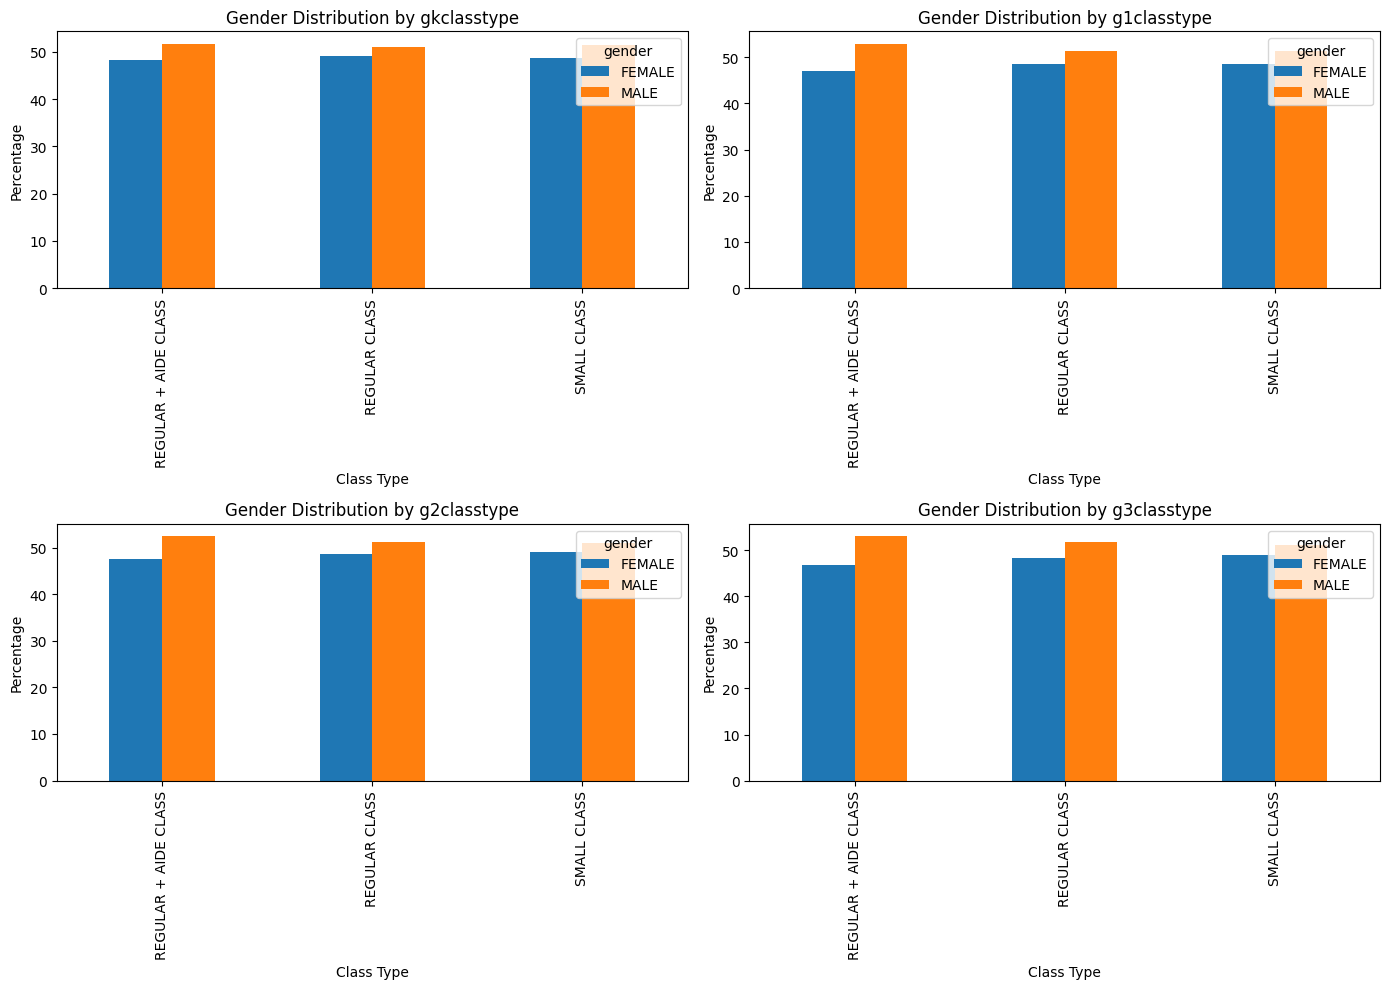

In [17]:
# Group by 'gkclasstype' and calculate the gender distribution
gender_distribution_gk = data_Students.groupby('gkclasstype')['gender'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Group by 'g1classtype' and calculate the gender distribution
gender_distribution_g1 = data_Students.groupby('g1classtype')['gender'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Group by 'g2classtype' and calculate the gender distribution
gender_distribution_g2 = data_Students.groupby('g2classtype')['gender'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Group by 'g3classtype' and calculate the gender distribution
gender_distribution_g3 = data_Students.groupby('g3classtype')['gender'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Plotting the distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot for gkclasstype
gender_distribution_gk.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Gender Distribution by gkclasstype')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].set_xlabel('Class Type')

# Plot for g1classtype
gender_distribution_g1.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution by g1classtype')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].set_xlabel('Class Type')

# Plot for g2classtype
gender_distribution_g2.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Gender Distribution by g2classtype')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_xlabel('Class Type')

# Plot for g3classtype
gender_distribution_g3.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Gender Distribution by g3classtype')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Class Type')

# Adjust layout
plt.tight_layout()
plt.show()

We found a similar gender distribution between the intervention groups for each of the grades (Kindergarten, 1st g, 2nd g, and 3rd g).

In [18]:
# Group by 'gkclasstype' and calculate the race distribution
race_distribution_gk = data_Students.groupby('gkclasstype')['race'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Display the race distribution table
print("Race Distribution Grouped by gkclasstype:")
display(race_distribution_gk)

# Group by 'g1classtype' and calculate the race distribution
race_distribution_g1 = data_Students.groupby('g1classtype')['race'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Display the race distribution table
print("Race Distribution Grouped by gkclasstype:")
display(race_distribution_g1)

# Group by 'g2classtype' and calculate the race distribution
race_distribution_g2 = data_Students.groupby('g2classtype')['race'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Display the race distribution table
print("Race Distribution Grouped by g2classtype:")
display(race_distribution_g2)


# Group by 'g3classtype' and calculate the race distribution
race_distribution_g3 = data_Students.groupby('g3classtype')['race'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Display the race distribution table
print("Race Distribution Grouped by g3classtype:")
display(race_distribution_g3)

Race Distribution Grouped by gkclasstype:


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


race,ASIAN,BLACK,HISPANIC,NATIVE AMERICAN,OTHER,WHITE
gkclasstype,,,,,,
REGULAR + AIDE CLASS,0.13,33.84,0.04,0.00,0.18,65.80
REGULAR CLASS,0.36,32.39,0.00,0.05,0.05,67.15
SMALL CLASS,0.16,31.23,0.21,0.05,0.21,68.14


Race Distribution Grouped by gkclasstype:


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


race,ASIAN,BLACK,HISPANIC,NATIVE AMERICAN,OTHER,WHITE
g1classtype,,,,,,
REGULAR + AIDE CLASS,0.22,28.84,0.17,0.13,0.17,70.47
REGULAR CLASS,0.39,37.19,0.08,0.12,0.16,62.07
SMALL CLASS,0.36,31.18,0.16,0.16,0.16,67.99


Race Distribution Grouped by g2classtype:


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


race,ASIAN,BLACK,HISPANIC,NATIVE AMERICAN,OTHER,WHITE
g2classtype,,,,,,
REGULAR + AIDE CLASS,0.16,34.89,0.24,0.08,0.16,64.46
REGULAR CLASS,0.26,36.32,0.13,0.04,0.13,63.11
SMALL CLASS,0.20,32.46,0.20,0.00,0.15,66.98


Race Distribution Grouped by g3classtype:


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


race,ASIAN,BLACK,HISPANIC,NATIVE AMERICAN,OTHER,WHITE
g3classtype,,,,,,
REGULAR + AIDE CLASS,0.16,35.09,0.04,0.0,0.12,64.59
REGULAR CLASS,0.29,33.17,0.10,0.0,0.14,66.30
SMALL CLASS,0.28,31.17,0.23,0.0,0.09,68.23


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


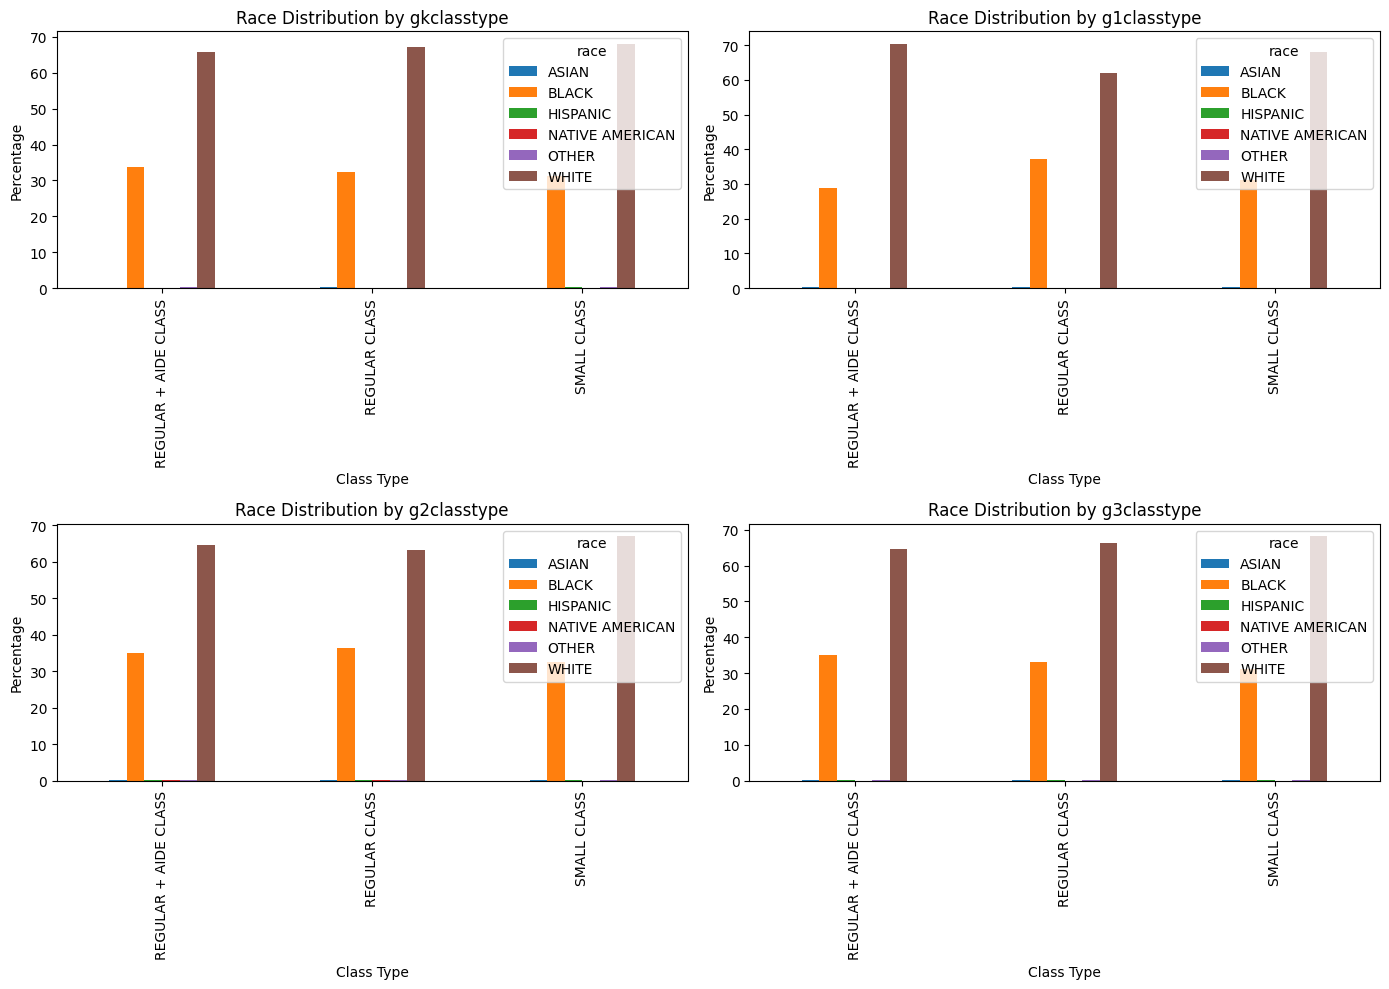

In [19]:
# Group by 'gkclasstype' and calculate the race distribution
race_distribution_gk = data_Students.groupby('gkclasstype')['race'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Group by 'g1classtype' and calculate the race distribution
race_distribution_g1 = data_Students.groupby('g1classtype')['race'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Group by 'g2classtype' and calculate the race distribution
race_distribution_g2 = data_Students.groupby('g2classtype')['race'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Group by 'g3classtype' and calculate the race distribution
race_distribution_g3 = data_Students.groupby('g3classtype')['race'].value_counts(normalize=True).mul(100).round(2).unstack(fill_value=0)

# Plotting the distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot for gkclasstype
race_distribution_gk.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Race Distribution by gkclasstype')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].set_xlabel('Class Type')

# Plot for g1classtype
race_distribution_g1.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Race Distribution by g1classtype')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].set_xlabel('Class Type')

# Plot for g2classtype
race_distribution_g2.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Race Distribution by g2classtype')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_xlabel('Class Type')

# Plot for g3classtype
race_distribution_g3.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Race Distribution by g3classtype')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Class Type')

# Save image
plt.savefig('distribucion_raza_por_classtype.png')

# Adjust layout
plt.tight_layout()
plt.show()

We also found a similar gender distribution between the intervention groups for each of the grades (Kindergarten, 1st g, 2nd g, and 3rd g). 

In [20]:
# Display the summary information Comparison Students
display(data_Comparison.head())

,stdntid,gender,race,preschol,kindrgrt,birthmonth,birthday,birthyear,flagg1c,flagg2c,...,g3mathcomputss,g3mathnumconcss,g3mathapplss,g3wordskillss,g3readbsraw,g3mathbsraw,g3readbspct,g3mathbspct,g3readbsobjpct,g3mathbsobjpct
0,30001.0,MALE,NaN,NO,YES,11.0,22.0,1979.0,YES,NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30002.0,MALE,NaN,NO,YES,8.0,5.0,1980.0,YES,NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30003.0,MALE,WHITE,NaN,YES,NaN,NaN,NaN,NO,YES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30004.0,MALE,WHITE,NO,YES,NaN,NaN,NaN,YES,YES,...,652.0,582.0,571.0,570.0,23.0,38.0,4.0,8.0,40.0,53.0
4,30005.0,MALE,NaN,NO,YES,3.0,17.0,1980.0,YES,NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
